In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, dimension, sequence)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    X_train = X_train.transpose((0,2,1))
    X_valid = X_valid.transpose((0,2,1))
    X_test = X_test.transpose((0,2,1))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
# 뒷 padding 제거
class Chomp1d(torch.nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

In [11]:
class CausalConvolutionBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,dilation, final = False):
        super().__init__()

        padding = (kernel_size - 1) * dilation

        conv1 = nn.utils.weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp1 = Chomp1d(padding)
        relu1 = nn.LeakyReLU()

        conv2 = nn.utils.weight_norm(nn.Conv1d(out_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp2 = Chomp1d(padding)
        relu2 = nn.LeakyReLU()

        # Causal network
        self.causal = torch.nn.Sequential(
            conv1, chomp1, relu1, conv2, chomp2, relu2
        )

        # Residual connection
        self.upordownsample = torch.nn.Conv1d(
            in_channels, out_channels, 1
        ) if in_channels != out_channels else None

        # Final activation function
        self.relu = torch.nn.LeakyReLU() if final else None

    def forward(self, x):
        out_causal = self.causal(x)
        res = x if self.upordownsample is None else self.upordownsample(x)
        if self.relu is None:
            return out_causal + res
        else:
            return self.relu(out_causal + res)


In [12]:
class CausalCNN(torch.nn.Module):
    def __init__(self, in_channels, channels, depth, out_channels,
                 kernel_size):
        super(CausalCNN, self).__init__()

        layers = []  # layer of convolution block
        dilation_size = 1  # initial setting

        for i in range(depth):
            in_channels_block = in_channels if i == 0 else channels
            layers += [CausalConvolutionBlock(
                in_channels_block, channels, kernel_size, dilation_size
            )]
            dilation_size *= 2  # 각 step이 지날수록 dilation이 2배로

        # last layer
        layers += [CausalConvolutionBlock(
            channels, out_channels, kernel_size, dilation_size
        )]

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [13]:
class SqueezeChannels(torch.nn.Module):
    def __init__(self):
        super(SqueezeChannels, self).__init__()

    def forward(self, x):
        return x.squeeze(2)

In [14]:
class CausalCNNEncoder(torch.nn.Module):
    '''
    (1,10,1056) tensor를 넣는다고 하자
    Causal_cnn(10,10,5,5,3)을 거치면 (1, 5, 1056)가 된다.
    AdaptiveMaxPool1d(1) 를 거치면 (1,5,1)이 된다.
    SqueezeChannels() 을 거치면 (1,5)가 된다.
    그 다음은 linear거쳐서 (1,2)가 되게 하고 이진 분류를 하면 된다.(마무리!!!!!!)
    '''
    def __init__(self, config):
        super(CausalCNNEncoder, self).__init__()
        causal_cnn = CausalCNN(
            config.in_channels, config.channels, config.depth, config.reduced_size, config.kernel_size
        )
        reduce_size = torch.nn.AdaptiveMaxPool1d(1)
        squeeze = SqueezeChannels()  # Squeezes the third dimension (time)
        linear = torch.nn.Linear(config.reduced_size, config.out_channels)
        self.network = torch.nn.Sequential(
            causal_cnn, reduce_size, squeeze, linear
        )

    def forward(self, x):
        return self.network(x.float())

# trainer 구현

In [15]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [16]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 3000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  in_channels = 19       # 처음 input의 차원의 개수 (feature수와 같다)
  channels = 19          # 중간의 차원
  depth = 5              # block 개수, block이 2이면 dilation도 2까지 한다고 생각하면 된다.
  reduced_size = 10      # 여러 block을 다 지나고 나온 차원의 개수
  out_channels = 2       # block거치고 linear 변환을 마친 차원의 개수, 여기가 2이면 이진분류
  kernel_size = 3        # kernel size인데 CasualCNNEncoder의 모든 커널의 size는 같다.

config = Config()

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [18]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [19]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


In [20]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 3000
failure(1)의 개수 : 1569


In [21]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [22]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [23]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [24]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 2741
Total number of data samples in valid_loader: 913
Total number of data samples in test_loader: 914


In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [26]:
# model, optimizer, loss_function 구현하고 결합시키기
model = CausalCNNEncoder(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [27]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/3000_tcn') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Model saved
TRAIN LOSS = 0.0029243259306416724, TRAIN ACC = 0.4990879241152864, 
VALID LOSS = 0.003013934389262706, VALID ACC = 0.592552026286966, 
epoch 2


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Model saved
TRAIN LOSS = 0.002547895634361359, TRAIN ACC = 0.669098869025903, 
VALID LOSS = 0.0027520347790545726, VALID ACC = 0.664841182913472, 
epoch 3


100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Model saved
TRAIN LOSS = 0.002346064673858331, TRAIN ACC = 0.7066763954761036, 
VALID LOSS = 0.002637952598789044, VALID ACC = 0.6998904709748083, 
epoch 4


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Model saved
TRAIN LOSS = 0.002211970880230775, TRAIN ACC = 0.7245530828164903, 
VALID LOSS = 0.0025169389140827893, VALID ACC = 0.7130339539978094, 
epoch 5


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Model saved
TRAIN LOSS = 0.002124208009664876, TRAIN ACC = 0.7249179131703758, 
VALID LOSS = 0.0024290520938568282, VALID ACC = 0.7272727272727273, 
epoch 6


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Model saved
TRAIN LOSS = 0.0020243149089012994, TRAIN ACC = 0.7409704487413353, 
VALID LOSS = 0.0023265396125475915, VALID ACC = 0.7316538882803943, 
epoch 7


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Model saved
TRAIN LOSS = 0.0019332385767728297, TRAIN ACC = 0.7570229843122948, 
VALID LOSS = 0.0022217754727517137, VALID ACC = 0.7393209200438116, 
epoch 8


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Model saved
TRAIN LOSS = 0.0018436600152091883, TRAIN ACC = 0.7719810288215979, 
VALID LOSS = 0.0021052565527641238, VALID ACC = 0.7623220153340635, 
epoch 9


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Model saved
TRAIN LOSS = 0.0017489650874884187, TRAIN ACC = 0.7730755198832543, 
VALID LOSS = 0.0020173734211059936, VALID ACC = 0.7656078860898138, 
epoch 10


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0016837087329048955, TRAIN ACC = 0.778547975191536, 
VALID LOSS = 0.0020177052289998285, VALID ACC = 0.7634173055859803, 
epoch 11


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0016017513786602611, TRAIN ACC = 0.7931411893469537, 
VALID LOSS = 0.0020033815734879995, VALID ACC = 0.7590361445783133, 
epoch 12


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Model saved
TRAIN LOSS = 0.0015416174789972873, TRAIN ACC = 0.804086099963517, 
VALID LOSS = 0.0018285012845794578, VALID ACC = 0.7907995618838992, 
epoch 13


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Model saved
TRAIN LOSS = 0.0014565160286683142, TRAIN ACC = 0.8219627873039037, 
VALID LOSS = 0.0017573101954026656, VALID ACC = 0.8039430449069004, 
epoch 14


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Model saved
TRAIN LOSS = 0.0014001840616133646, TRAIN ACC = 0.8299890550893835, 
VALID LOSS = 0.0016828386637362828, VALID ACC = 0.8148959474260679, 
epoch 15


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.0013569131118457102, TRAIN ACC = 0.8350966800437797, 
VALID LOSS = 0.001822159298147847, VALID ACC = 0.7951807228915663, 
epoch 16


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Model saved
TRAIN LOSS = 0.001246005927329079, TRAIN ACC = 0.8595403137541043, 
VALID LOSS = 0.0016146367181170025, VALID ACC = 0.8258488499452354, 
epoch 17


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Model saved
TRAIN LOSS = 0.0012025392564358132, TRAIN ACC = 0.8588106530463334, 
VALID LOSS = 0.0015868067676109657, VALID ACC = 0.8302300109529025, 
epoch 18


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.001129545399151941, TRAIN ACC = 0.8752280189711784, 
VALID LOSS = 0.0015633741448769043, VALID ACC = 0.8291347207009858, 
epoch 19


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Model saved
TRAIN LOSS = 0.0011076434321405243, TRAIN ACC = 0.8763225100328347, 
VALID LOSS = 0.0015699303293802652, VALID ACC = 0.8422782037239869, 
epoch 20


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.001042539889209682, TRAIN ACC = 0.8817949653411163, 
VALID LOSS = 0.0014687886896164759, VALID ACC = 0.836801752464403, 
epoch 21


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.001018301908311423, TRAIN ACC = 0.8803356439255746, 
VALID LOSS = 0.0016293747662714513, VALID ACC = 0.828039430449069, 
epoch 22


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Model saved
TRAIN LOSS = 0.0010215684537772756, TRAIN ACC = 0.8901860634804816, 
VALID LOSS = 0.0014008936132554287, VALID ACC = 0.8587075575027382, 
epoch 23


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.0009091161476874256, TRAIN ACC = 0.9018606348048157, 
VALID LOSS = 0.0014465645135167133, VALID ACC = 0.8400876232201533, 
epoch 24


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.0009424178074503067, TRAIN ACC = 0.8927398759576797, 
VALID LOSS = 0.001524953630641674, VALID ACC = 0.8510405257393209, 
epoch 25


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


TRAIN LOSS = 0.0008895975510076378, TRAIN ACC = 0.9051441079897847, 
VALID LOSS = 0.0014230223762244803, VALID ACC = 0.8488499452354874, 
epoch 26


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


TRAIN LOSS = 0.0008594396013449857, TRAIN ACC = 0.9106165632980664, 
VALID LOSS = 0.0014528843358991442, VALID ACC = 0.8532311062431545, 
epoch 27


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Model saved
TRAIN LOSS = 0.000797673249844868, TRAIN ACC = 0.9157241882524626, 
VALID LOSS = 0.0013372540343369215, VALID ACC = 0.8619934282584885, 
epoch 28


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0007587926138147565, TRAIN ACC = 0.9219263042685152, 
VALID LOSS = 0.0015246031840555248, VALID ACC = 0.8532311062431545, 
epoch 29


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.0007217583191825368, TRAIN ACC = 0.9252097774534841, 
VALID LOSS = 0.001455613647598818, VALID ACC = 0.8576122672508215, 
epoch 30


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.0007456186717115846, TRAIN ACC = 0.9241152863918278, 
VALID LOSS = 0.0015717193827049364, VALID ACC = 0.8488499452354874, 
epoch 31


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Model saved
TRAIN LOSS = 0.000727411099960664, TRAIN ACC = 0.9171835096680043, 
VALID LOSS = 0.0014861488525081438, VALID ACC = 0.8630887185104053, 
epoch 32


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0006747033660405746, TRAIN ACC = 0.9306822327617658, 
VALID LOSS = 0.0014557569468269472, VALID ACC = 0.8565169769989047, 
epoch 33


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Model saved
TRAIN LOSS = 0.0007232351976778767, TRAIN ACC = 0.9255746078073696, 
VALID LOSS = 0.0014845780775293723, VALID ACC = 0.8652792990142387, 
epoch 34


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Model saved
TRAIN LOSS = 0.0006559278050812001, TRAIN ACC = 0.9321415541773076, 
VALID LOSS = 0.0014048554941701733, VALID ACC = 0.872946330777656, 
epoch 35


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


TRAIN LOSS = 0.0006397976568909902, TRAIN ACC = 0.9365195184239329, 
VALID LOSS = 0.0013602447144173062, VALID ACC = 0.8696604600219058, 
epoch 36


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.000618172576396146, TRAIN ACC = 0.9368843487778183, 
VALID LOSS = 0.00142963738195998, VALID ACC = 0.8652792990142387, 
epoch 37


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.0007069055799670743, TRAIN ACC = 0.9222911346224005, 
VALID LOSS = 0.0014015897080253276, VALID ACC = 0.8707557502738226, 
epoch 38


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.000615453288442938, TRAIN ACC = 0.9365195184239329, 
VALID LOSS = 0.001743326997965868, VALID ACC = 0.8554216867469879, 
epoch 39


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.0005886489155082883, TRAIN ACC = 0.9394381612550164, 
VALID LOSS = 0.0014139669421990887, VALID ACC = 0.8630887185104053, 
epoch 40


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Model saved
TRAIN LOSS = 0.000551658538800441, TRAIN ACC = 0.9449106165632981, 
VALID LOSS = 0.0013200836041932038, VALID ACC = 0.8806133625410734, 
epoch 41


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.0004957304878071337, TRAIN ACC = 0.9529368843487778, 
VALID LOSS = 0.0014674853847687502, VALID ACC = 0.8740416210295728, 
epoch 42


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0004653803561126085, TRAIN ACC = 0.9543962057643196, 
VALID LOSS = 0.0014673087578613681, VALID ACC = 0.8773274917853231, 
epoch 43


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00048386860082985406, TRAIN ACC = 0.952207223641007, 
VALID LOSS = 0.0016933193538431791, VALID ACC = 0.8652792990142387, 
epoch 44


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.000410153583882717, TRAIN ACC = 0.9649762860269975, 
VALID LOSS = 0.0018149278772360393, VALID ACC = 0.8532311062431545, 
epoch 45


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0004395606286418738, TRAIN ACC = 0.9584093396570594, 
VALID LOSS = 0.0017057765287480768, VALID ACC = 0.8696604600219058, 
epoch 46


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0005251836359218192, TRAIN ACC = 0.9478292593943816, 
VALID LOSS = 0.001665325849628135, VALID ACC = 0.8587075575027382, 
epoch 47


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0005172252497373816, TRAIN ACC = 0.9503830718715797, 
VALID LOSS = 0.0016155990426146058, VALID ACC = 0.8707557502738226, 
epoch 48


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 0.00045192759757231555, TRAIN ACC = 0.9558555271798613, 
VALID LOSS = 0.0017802858927163732, VALID ACC = 0.8565169769989047, 
epoch 49


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.0003845645471542954, TRAIN ACC = 0.9649762860269975, 
VALID LOSS = 0.0016379305462455957, VALID ACC = 0.8587075575027382, 
epoch 50


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.0003841525471719326, TRAIN ACC = 0.9620576431959139, 
VALID LOSS = 0.0016702295720642524, VALID ACC = 0.8674698795180723, 
epoch 51


100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


TRAIN LOSS = 0.00037252438716408286, TRAIN ACC = 0.9631521342575702, 
VALID LOSS = 0.002003313840937118, VALID ACC = 0.8652792990142387, 
epoch 52


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 0.00034380767770337173, TRAIN ACC = 0.9700839109813937, 
VALID LOSS = 0.0017188847848384561, VALID ACC = 0.8773274917853231, 
epoch 53


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0003245088527647086, TRAIN ACC = 0.9722728931047063, 
VALID LOSS = 0.0015792450077040173, VALID ACC = 0.8740416210295728, 
epoch 54


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


TRAIN LOSS = 0.0003399199410995746, TRAIN ACC = 0.9682597592119664, 
VALID LOSS = 0.0019146929630705718, VALID ACC = 0.8762322015334063, 
epoch 55


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 0.00028992381758256706, TRAIN ACC = 0.9755563662896753, 
VALID LOSS = 0.0019318429428802524, VALID ACC = 0.8685651697699891, 
epoch 56


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00025613881737287353, TRAIN ACC = 0.9784750091207588, 
VALID LOSS = 0.001903727732247878, VALID ACC = 0.8696604600219058, 
epoch 57


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0002573466554300405, TRAIN ACC = 0.9770156877052171, 
VALID LOSS = 0.0019874893626665364, VALID ACC = 0.8718510405257394, 
epoch 58


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0003243317186767191, TRAIN ACC = 0.9719080627508209, 
VALID LOSS = 0.0018291302996423394, VALID ACC = 0.8696604600219058, 
epoch 59


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 0.00041049050451934184, TRAIN ACC = 0.9638817949653411, 
VALID LOSS = 0.0022034798172452493, VALID ACC = 0.8576122672508215, 
epoch 60


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.0003693756130610622, TRAIN ACC = 0.964611455673112, 
VALID LOSS = 0.001790199424716494, VALID ACC = 0.8696604600219058, 
epoch 61


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00027622015306176344, TRAIN ACC = 0.9773805180591025, 
VALID LOSS = 0.0018741782562886767, VALID ACC = 0.8762322015334063, 
epoch 62


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.00029987641921099066, TRAIN ACC = 0.9722728931047063, 
VALID LOSS = 0.0020343218353726907, VALID ACC = 0.8696604600219058, 
epoch 63


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00036571236970823904, TRAIN ACC = 0.9642466253192266, 
VALID LOSS = 0.002257384188465064, VALID ACC = 0.8587075575027382, 
epoch 64


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00028940394863252527, TRAIN ACC = 0.9751915359357899, 
VALID LOSS = 0.001783693117484336, VALID ACC = 0.8685651697699891, 
epoch 65


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0002646299526883668, TRAIN ACC = 0.9784750091207588, 
VALID LOSS = 0.0020731176695452853, VALID ACC = 0.8685651697699891, 
epoch 66


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00024031229053523062, TRAIN ACC = 0.9788398394746443, 
VALID LOSS = 0.0020713079863545147, VALID ACC = 0.8751369112814896, 
epoch 67


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.00019740425621080207, TRAIN ACC = 0.9854067858445823, 
VALID LOSS = 0.00222744633569122, VALID ACC = 0.8696604600219058, 
epoch 68


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00019069544601314306, TRAIN ACC = 0.983582634075155, 
VALID LOSS = 0.0023310079044475745, VALID ACC = 0.8685651697699891, 
epoch 69


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.0001981240744433756, TRAIN ACC = 0.9839474644290405, 
VALID LOSS = 0.002343096908055417, VALID ACC = 0.8773274917853231, 
epoch 70


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0001626110607496538, TRAIN ACC = 0.9850419554906968, 
VALID LOSS = 0.0023272893057987177, VALID ACC = 0.8707557502738226, 
epoch 71


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00016754512960177537, TRAIN ACC = 0.9872309376140095, 
VALID LOSS = 0.0023170760205384806, VALID ACC = 0.8762322015334063, 
epoch 72


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.00015798185478701552, TRAIN ACC = 0.9883254286756659, 
VALID LOSS = 0.002411724899580288, VALID ACC = 0.8806133625410734, 
epoch 73


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.00021223415237019331, TRAIN ACC = 0.9821233126596133, 
VALID LOSS = 0.002727409149443594, VALID ACC = 0.8674698795180723, 
epoch 74


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.00018964791300087156, TRAIN ACC = 0.9861364465523531, 
VALID LOSS = 0.0022166684384152765, VALID ACC = 0.8751369112814896, 
epoch 75


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.0001520423041245486, TRAIN ACC = 0.9890550893834367, 
VALID LOSS = 0.0025481308146348266, VALID ACC = 0.8718510405257394, 
epoch 76


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.0001704734367845442, TRAIN ACC = 0.9824881430134987, 
VALID LOSS = 0.002343433449067265, VALID ACC = 0.8773274917853231, 
epoch 77


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.0002115296002168892, TRAIN ACC = 0.9824881430134987, 
VALID LOSS = 0.002809241463033419, VALID ACC = 0.8674698795180723, 
epoch 78


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.0003005090580396259, TRAIN ACC = 0.9722728931047063, 
VALID LOSS = 0.002820146664862826, VALID ACC = 0.859802847754655, 
epoch 79


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.00028950685485028645, TRAIN ACC = 0.9719080627508209, 
VALID LOSS = 0.0020353079886713268, VALID ACC = 0.8740416210295728, 
epoch 80


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.00020778554959568566, TRAIN ACC = 0.9799343305363006, 
VALID LOSS = 0.0022243326295244732, VALID ACC = 0.8674698795180723, 
epoch 81


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00024820264158393295, TRAIN ACC = 0.9770156877052171, 
VALID LOSS = 0.002345093402517847, VALID ACC = 0.8762322015334063, 
epoch 82


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00015628842697422768, TRAIN ACC = 0.9861364465523531, 
VALID LOSS = 0.0024769169085649906, VALID ACC = 0.8707557502738226, 
epoch 83


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 0.00013237142210315936, TRAIN ACC = 0.990879241152864, 
VALID LOSS = 0.002323097427990716, VALID ACC = 0.8806133625410734, 
epoch 84


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.0001276430647734611, TRAIN ACC = 0.9890550893834367, 
VALID LOSS = 0.002309529537177948, VALID ACC = 0.8696604600219058, 
epoch 85


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.00013698732384590282, TRAIN ACC = 0.9879605983217804, 
VALID LOSS = 0.0024213041102376983, VALID ACC = 0.8773274917853231, 
epoch 86


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.00016874918256828882, TRAIN ACC = 0.9872309376140095, 
VALID LOSS = 0.002433341735033451, VALID ACC = 0.8806133625410734, 
epoch 87


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 0.00014403415521058407, TRAIN ACC = 0.9883254286756659, 
VALID LOSS = 0.002344885700242543, VALID ACC = 0.8663745892661555, 
epoch 88


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.00015641743095033754, TRAIN ACC = 0.9875957679678949, 
VALID LOSS = 0.0024820025622648845, VALID ACC = 0.8696604600219058, 
epoch 89


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 0.00011523212287513847, TRAIN ACC = 0.9923385625684057, 
VALID LOSS = 0.0026373139216369764, VALID ACC = 0.8718510405257394, 
epoch 90


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.00011389983620186089, TRAIN ACC = 0.9930682232761766, 
VALID LOSS = 0.00311611232073388, VALID ACC = 0.8630887185104053, 
epoch 91


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.0001490786399818693, TRAIN ACC = 0.9854067858445823, 
VALID LOSS = 0.0027040105725170357, VALID ACC = 0.8740416210295728, 
epoch 92


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 9.550962159501858e-05, TRAIN ACC = 0.9945275446917183, 
VALID LOSS = 0.002808688895987002, VALID ACC = 0.8663745892661555, 
epoch 93


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 7.921425266879747e-05, TRAIN ACC = 0.9948923750456038, 
VALID LOSS = 0.0028046189367705865, VALID ACC = 0.8751369112814896, 
epoch 94


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 6.553035522330333e-05, TRAIN ACC = 0.9963516964611455, 
VALID LOSS = 0.002782406446575988, VALID ACC = 0.8696604600219058, 
epoch 95


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 6.735532343066857e-05, TRAIN ACC = 0.9959868661072602, 
VALID LOSS = 0.0029309274463507327, VALID ACC = 0.8762322015334063, 
epoch 96


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 4.883113224433096e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.0028639274515693054, VALID ACC = 0.872946330777656, 
epoch 97


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 4.221310408222593e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.0028300691408238822, VALID ACC = 0.872946330777656, 
epoch 98


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 4.440410074902599e-05, TRAIN ACC = 0.9974461875228019, 
VALID LOSS = 0.0029198989549576258, VALID ACC = 0.8762322015334063, 
epoch 99


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 4.124194988420261e-05, TRAIN ACC = 0.9974461875228019, 
VALID LOSS = 0.003047930972338506, VALID ACC = 0.8740416210295728, 
epoch 100


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 3.5323985790801894e-05, TRAIN ACC = 0.9981758482305728, 
VALID LOSS = 0.0034006276501491583, VALID ACC = 0.8674698795180723, 
epoch 101


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 3.6221577567434015e-05, TRAIN ACC = 0.9981758482305728, 
VALID LOSS = 0.0030834867424144935, VALID ACC = 0.8751369112814896, 
epoch 102


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 4.244021483041572e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.0033158992232524293, VALID ACC = 0.8685651697699891, 
epoch 103


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 3.117955497383462e-05, TRAIN ACC = 0.9985406785844583, 
VALID LOSS = 0.0032104769515573393, VALID ACC = 0.8696604600219058, 
epoch 104


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 2.7688094171831662e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.0035184189954697107, VALID ACC = 0.8696604600219058, 
epoch 105


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 2.9256791610301997e-05, TRAIN ACC = 0.9981758482305728, 
VALID LOSS = 0.0033356620474164615, VALID ACC = 0.8740416210295728, 
epoch 106


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 3.2570425566083344e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.0034909115824746408, VALID ACC = 0.8696604600219058, 
epoch 107


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 2.8979214204258506e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.0033862462179553732, VALID ACC = 0.8707557502738226, 
epoch 108


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 2.313446005842343e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.0038872036066922274, VALID ACC = 0.8740416210295728, 
epoch 109


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 2.4381030610171667e-05, TRAIN ACC = 0.9985406785844583, 
VALID LOSS = 0.003783783737696536, VALID ACC = 0.8740416210295728, 
epoch 110


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 2.4555060728454798e-05, TRAIN ACC = 0.9985406785844583, 
VALID LOSS = 0.003820819113105699, VALID ACC = 0.8685651697699891, 
epoch 111


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


Model saved
TRAIN LOSS = 2.2468721818223742e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.003720020608076783, VALID ACC = 0.8817086527929902, 
epoch 112


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 3.07266029608441e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.004251651865759659, VALID ACC = 0.8652792990142387, 
epoch 113


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 7.474265852654254e-05, TRAIN ACC = 0.9941627143378329, 
VALID LOSS = 0.0038616598501132328, VALID ACC = 0.8652792990142387, 
epoch 114


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.00025811718130570524, TRAIN ACC = 0.9795695001824152, 
VALID LOSS = 0.0035873952465537867, VALID ACC = 0.8630887185104053, 
epoch 115


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.0006777518631028068, TRAIN ACC = 0.9518423932871215, 
VALID LOSS = 0.002997345234974321, VALID ACC = 0.8532311062431545, 
epoch 116


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 0.0010901621846289846, TRAIN ACC = 0.9233856256840569, 
VALID LOSS = 0.0023097910011454456, VALID ACC = 0.8532311062431545, 
epoch 117


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 0.0006935942547028189, TRAIN ACC = 0.9398029916089019, 
VALID LOSS = 0.0018838582007542888, VALID ACC = 0.8630887185104053, 
epoch 118


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.00042701768629396975, TRAIN ACC = 0.9602334914264867, 
VALID LOSS = 0.0015990761846206014, VALID ACC = 0.8740416210295728, 
epoch 119


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.00027526888027325116, TRAIN ACC = 0.9770156877052171, 
VALID LOSS = 0.0016353186485148468, VALID ACC = 0.8773274917853231, 
epoch 120


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.0001695771001358182, TRAIN ACC = 0.990149580445093, 
VALID LOSS = 0.0020021464581818594, VALID ACC = 0.8773274917853231, 
epoch 121


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 0.0001033606902661875, TRAIN ACC = 0.9963516964611455, 
VALID LOSS = 0.002037094495904929, VALID ACC = 0.8751369112814896, 
epoch 122


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 8.324052647859761e-05, TRAIN ACC = 0.9945275446917183, 
VALID LOSS = 0.002171654788713988, VALID ACC = 0.8751369112814896, 
epoch 123


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 6.809684953189209e-05, TRAIN ACC = 0.9963516964611455, 
VALID LOSS = 0.002308223294532834, VALID ACC = 0.8806133625410734, 
epoch 124


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 5.4087914222024384e-05, TRAIN ACC = 0.9978110178766874, 
VALID LOSS = 0.002415945045527597, VALID ACC = 0.8762322015334063, 
epoch 125


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 4.797356780135949e-05, TRAIN ACC = 0.9981758482305728, 
VALID LOSS = 0.002598525366673464, VALID ACC = 0.8751369112814896, 
epoch 126


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 3.946544383358603e-05, TRAIN ACC = 0.9985406785844583, 
VALID LOSS = 0.002728345947746118, VALID ACC = 0.8751369112814896, 
epoch 127


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 3.5648883583037054e-05, TRAIN ACC = 0.9985406785844583, 
VALID LOSS = 0.0028025512170426034, VALID ACC = 0.872946330777656, 
epoch 128


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 3.243715508097891e-05, TRAIN ACC = 0.9985406785844583, 
VALID LOSS = 0.002982094280038188, VALID ACC = 0.8740416210295728, 
epoch 129


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 3.236032564047587e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.0028973931420149704, VALID ACC = 0.8740416210295728, 
epoch 130


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 2.876374473342035e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.0031127772025706865, VALID ACC = 0.872946330777656, 
epoch 131


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 2.1372187001965682e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.0031974401818700583, VALID ACC = 0.8740416210295728, 
epoch 132


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 2.3432379905834376e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.0029829420304376742, VALID ACC = 0.8795180722891566, 
epoch 133


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 2.064075811423935e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.003018447237756401, VALID ACC = 0.872946330777656, 
epoch 134


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 1.3438599829387704e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.003058599028634346, VALID ACC = 0.8740416210295728, 
epoch 135


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 1.1214613753096743e-05, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031843013074024616, VALID ACC = 0.8751369112814896, 
epoch 136


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 1.0269085536189364e-05, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033689013968945074, VALID ACC = 0.8718510405257394, 
epoch 137


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 1.0126246017428025e-05, TRAIN ACC = 1.0, 
VALID LOSS = 0.003518962259491067, VALID ACC = 0.8707557502738226, 
epoch 138


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 1.2119838441948045e-05, TRAIN ACC = 0.9996351696461145, 
VALID LOSS = 0.0033923071551035687, VALID ACC = 0.872946330777656, 
epoch 139


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 1.2669029825022841e-05, TRAIN ACC = 0.9992703392922291, 
VALID LOSS = 0.004012170456847643, VALID ACC = 0.8751369112814896, 
epoch 140


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 1.9757238851907054e-05, TRAIN ACC = 0.9989055089383436, 
VALID LOSS = 0.003954593545113571, VALID ACC = 0.8784227820372399, 
epoch 141


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 1.2785861668214664e-05, TRAIN ACC = 1.0, 
VALID LOSS = 0.003624403463658211, VALID ACC = 0.872946330777656, 
epoch 142


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 6.954341663733337e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003575186544023495, VALID ACC = 0.8762322015334063, 
epoch 143


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 5.767602152919919e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003611128862951306, VALID ACC = 0.872946330777656, 
epoch 144


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 4.9062579707471895e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0037520291510181906, VALID ACC = 0.8707557502738226, 
epoch 145


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 4.809961688393215e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0035922888335889165, VALID ACC = 0.8696604600219058, 
epoch 146


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 4.56102744196071e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003792174478741883, VALID ACC = 0.872946330777656, 
epoch 147


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 4.191322110128507e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0038122741050553087, VALID ACC = 0.8707557502738226, 
epoch 148


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 3.5844056949288534e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003648700941300993, VALID ACC = 0.872946330777656, 
epoch 149


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 3.292063239330561e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003786461376804381, VALID ACC = 0.8685651697699891, 
epoch 150


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 2.9049081915078243e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0038903490084285673, VALID ACC = 0.8696604600219058, 
epoch 151


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 2.794387228858298e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0039933380004740756, VALID ACC = 0.8674698795180723, 
epoch 152


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


TRAIN LOSS = 2.508377919666026e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0040770994350395745, VALID ACC = 0.8696604600219058, 
epoch 153


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 2.3460655705238815e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004127733417565303, VALID ACC = 0.8685651697699891, 
epoch 154


100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


TRAIN LOSS = 2.2160591633561613e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004048328410103705, VALID ACC = 0.8663745892661555, 
epoch 155


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 2.039409339321259e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004204877104451074, VALID ACC = 0.8696604600219058, 
epoch 156


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 1.963124621441382e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004111036739892531, VALID ACC = 0.8685651697699891, 
epoch 157


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 1.8520235571234233e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004139701808269287, VALID ACC = 0.8685651697699891, 
epoch 158


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 1.7436555877602456e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004171476828960573, VALID ACC = 0.8674698795180723, 
epoch 159


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 1.635323692918767e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004396080513773455, VALID ACC = 0.8696604600219058, 
epoch 160


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 1.5674611149727483e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004634701996747923, VALID ACC = 0.8674698795180723, 
epoch 161


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 1.4621915037236464e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004282384098947114, VALID ACC = 0.8674698795180723, 
epoch 162


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 1.390004678966905e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004313615888259236, VALID ACC = 0.8685651697699891, 
epoch 163


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 1.3532710181541036e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004578773189348302, VALID ACC = 0.8663745892661555, 
epoch 164


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 1.3475125317116238e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0044114389268095884, VALID ACC = 0.8696604600219058, 
epoch 165


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 1.2513593688508001e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004433356788568403, VALID ACC = 0.8696604600219058, 
epoch 166


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 1.2421643316259201e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004457423485905291, VALID ACC = 0.8663745892661555, 
epoch 167


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 1.1443383515184213e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004397282268758149, VALID ACC = 0.8696604600219058, 
epoch 168


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 1.084487277146127e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.004868475787610893, VALID ACC = 0.8674698795180723, 
epoch 169


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 1.0809057354549912e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0044426832507238985, VALID ACC = 0.8685651697699891, 
epoch 170


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 9.934091385202847e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0047439529365673255, VALID ACC = 0.8685651697699891, 
epoch 171


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 9.7901993292268e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0046485322328674045, VALID ACC = 0.8674698795180723, 
epoch 172


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 9.327536288590063e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004607738892324392, VALID ACC = 0.8663745892661555, 
epoch 173


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 8.742741508044463e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0046990927051740565, VALID ACC = 0.8696604600219058, 
epoch 174


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 8.857421218004758e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004575326304315607, VALID ACC = 0.8685651697699891, 
epoch 175


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 8.350540502654339e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00476820876277159, VALID ACC = 0.8674698795180723, 
epoch 176


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 7.900639852683547e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004791789221998635, VALID ACC = 0.8685651697699891, 
epoch 177


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 7.937068350649473e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005006291127283236, VALID ACC = 0.8685651697699891, 
epoch 178


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 7.459605359220902e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005011522299880397, VALID ACC = 0.8674698795180723, 
epoch 179


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 7.230631318186274e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004776524753194519, VALID ACC = 0.8685651697699891, 
epoch 180


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 7.010703806268287e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004884132680861608, VALID ACC = 0.8685651697699891, 
epoch 181


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 6.9569154468048e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004831303706696626, VALID ACC = 0.8674698795180723, 
epoch 182


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


TRAIN LOSS = 6.608247682377451e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004700765291153405, VALID ACC = 0.8674698795180723, 
epoch 183


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 6.459141437863657e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004843857241355837, VALID ACC = 0.8674698795180723, 
epoch 184


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


TRAIN LOSS = 6.20733819719654e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005072345086021465, VALID ACC = 0.8685651697699891, 
epoch 185


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 6.130454392734384e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004941626746709349, VALID ACC = 0.8674698795180723, 
epoch 186


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 5.864148689991163e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.004964905265649334, VALID ACC = 0.8685651697699891, 
epoch 187


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 5.762521479929811e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005224870238351143, VALID ACC = 0.8685651697699891, 
epoch 188


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 5.572754710283102e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0053467132306177275, VALID ACC = 0.8674698795180723, 
epoch 189


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 5.386431132953252e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005053388197607435, VALID ACC = 0.8674698795180723, 
epoch 190


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 5.267095102113799e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005144887855776299, VALID ACC = 0.8674698795180723, 
epoch 191


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 5.094146014343089e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005110739943492843, VALID ACC = 0.8674698795180723, 
epoch 192


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 5.24037157955645e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005004478702148237, VALID ACC = 0.8685651697699891, 
epoch 193


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 4.881248176439343e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0051207946529785355, VALID ACC = 0.8674698795180723, 
epoch 194


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 4.787116941411676e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005141011530049921, VALID ACC = 0.8674698795180723, 
epoch 195


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 4.835960065283592e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005041042006159404, VALID ACC = 0.8674698795180723, 
epoch 196


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


TRAIN LOSS = 4.4897543139637143e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0052638156390529605, VALID ACC = 0.8685651697699891, 
epoch 197


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


TRAIN LOSS = 4.440655921042558e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00500627513260857, VALID ACC = 0.8674698795180723, 
epoch 198


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


TRAIN LOSS = 4.3969589511247876e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005309428795274481, VALID ACC = 0.8674698795180723, 
epoch 199


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


TRAIN LOSS = 4.195864609122753e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005156327769372445, VALID ACC = 0.8674698795180723, 
epoch 200


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

TRAIN LOSS = 4.225334891950387e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.005318428704929247, VALID ACC = 0.8674698795180723, 


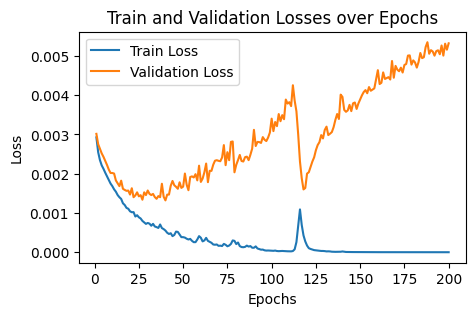

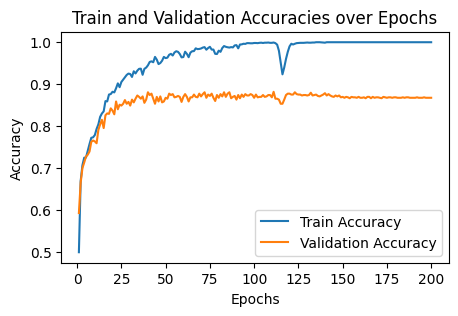

In [28]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH )
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH )

In [28]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/3000_tcn_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

Best epoch: 111
macro F1 Score: 0.8628224237154805
AUROC: 0.9413051985500083
Accuracy: 0.8730853391684902


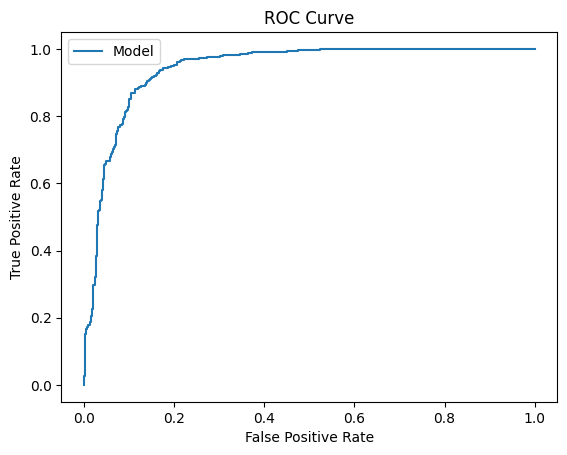

: 

In [31]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)